In [1]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
data=pd.read_csv('Fraud.csv')

In [3]:
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


## 1. Data cleaning
### i.Finding any nan values


In [4]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Here there is no any nan values in any column


### ii.Multi-collinearity
#### Multi-collinearity means the presence of high correlations between two or more independent variables


* Here we find the collinearity between 'type', 'amount',  'oldbalanceOrg', 'newbalanceOrig','oldbalanceDest', 'newbalanceDest'  for that we have to drop some of the columns which are not necessary and string elements
* In type column we have to convert the string element into integers for to find the correlation.
* And drop the string type columns like 'nameOrig', 'nameDest','isFraud','isFlaggedFraud'.

In [5]:
data1=data.copy(deep=True)
data1['type']=data1['type'].map({'CASH_IN':0,'CASH_OUT':1,'DEBIT':2,'PAYMENT':3,'TRANSFER':4})

In [6]:
data1=data1.drop(columns=[ 'nameOrig', 'nameDest','isFraud','isFlaggedFraud'])

In [7]:
data1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1,3,9839.64,170136.0,160296.36,0.0,0.0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0
2,1,4,181.00,181.0,0.00,0.0,0.0
3,1,1,181.00,181.0,0.00,21182.0,0.0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0


Variance Inflation Factor(VIF).

In VIF method, we pick each feature and regress it against all of the other features

In [8]:

vif_data = pd.DataFrame()
vif_data["feature"] = data1.columns
  
# calculating VIF for each feature

vif_data["VIF"] = [variance_inflation_factor(data1.values, i) for i in range(len(data1.columns))]
  
print(vif_data)

          feature         VIF
0            step    2.235180
1            type    2.075260
2          amount    4.013539
3   oldbalanceOrg  480.226670
4  newbalanceOrig  483.729602
5  oldbalanceDest   72.071759
6  newbalanceDest   83.549914


In this we found that oldbalenceOrig and newbalenceOrig have highest vif values.i.e oldbalenceOrig and newbalenceOrig realted with each other

## iii.Outlier

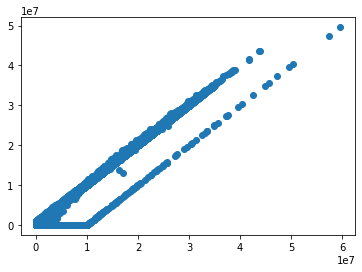

In [9]:
plt.scatter(data['oldbalanceOrg'],data['newbalanceOrig'])

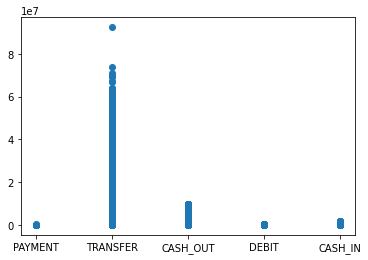

In [10]:
plt.scatter(data['type'],data1['amount'])

* the outlier points are very less these points doesn't effects the accuracy of model

## 2.fraud deetection model
### find which transaction is fraud

* With the help of 'isfraud' column we can find number of transactions are fraud 

In [11]:
Frauds_data=data.loc[data['isFraud']==1]
Fraud_transactions=Frauds_data['type'].drop_duplicates().values
print('mostly fraud transactions are takes place at',Fraud_transactions)

mostly fraud transactions are takes place at ['TRANSFER' 'CASH_OUT']


In [12]:
Frauds_data=data.loc[data['isFraud']==1]
Fraud_transactions=Frauds_data['type'].drop_duplicates().values
print('mostly fraud transactions are takes place at',Fraud_transactions)

mostly fraud transactions are takes place at ['TRANSFER' 'CASH_OUT']


In [13]:
fraud_cashout=data.loc[(data.isFraud==1) &( data.type=='CASH_OUT')]
fraud_transfer=data.loc[(data.isFraud==1) &( data.type=='TRANSFER')]
print('fraud transfer in cash_out type is ',len(fraud_cashout))
print('fraud transfer in Transfer type is ',len(fraud_transfer))

fraud transfer in cash_out type is  4116
fraud transfer in Transfer type is  4097


* Here we find count of fraud Transactions at 'TRANSFER' type and 'CASH_OUT' type

### check the fraud transactions by using isFlaggedFraud column

In [14]:
isflaggedfraud_count=len(data.loc[data.isFlaggedFraud==1])
print('the number of isflaggedfraud transactions is ',isflaggedfraud_count)

the number of isflaggedfraud transactions is  16


### Checking of fraud transactions using newbalence and old balence of destination and amount is not equal to 0
* if both oldbalenceDest and newbalenceDest is zero even transfered amount is not equal to 0 then the transaction is fraud transaction

In [15]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Missing Transactions are

In [16]:
missing_transactions=data1.loc[(data1['oldbalanceDest']==0) & (data1['newbalanceDest']==0) & (data1.amount !=0)].values
print('the missing transactions are',len(missing_transactions))

the missing transactions are 2317276


In [17]:
data1.loc[(data1['oldbalanceOrg']==0) & (data1['newbalanceOrig']==0) & (data1.amount !=0)]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
29,1,3,9920.52,0.0,0.0,0.00,0.00
30,1,3,3448.92,0.0,0.0,0.00,0.00
31,1,3,4206.84,0.0,0.0,0.00,0.00
32,1,3,5885.56,0.0,0.0,0.00,0.00
33,1,3,5307.88,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...,...
6355984,709,3,3837.05,0.0,0.0,0.00,0.00
6356000,709,1,104570.26,0.0,0.0,2890040.30,2994610.55
6356051,709,1,244966.80,0.0,0.0,5254563.09,5499529.89
6356052,709,1,123403.11,0.0,0.0,606875.62,730278.74


## training the data

### 3. In this 'type', 'amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest',	'newbalanceDest' are the independent variables .These independent varibles helps to get accuracy

In [18]:
x=data.loc[(data.type == 'TRANSFER') | (data.type == 'CASH_OUT')]
y=x.isFraud
x=x.drop(columns=[ 'nameOrig', 'nameDest','isFraud','isFlaggedFraud'],axis=1)
x.type=x.type.map({'CASH_OUT':1,'TRANSFER':4})
print(len(x),len(y))

2770409 2770409


In [19]:
x.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,1,4,181.00,181.0,0.0,0.0,0.00
3,1,1,181.00,181.0,0.0,21182.0,0.00
15,1,1,229133.94,15325.0,0.0,5083.0,51513.44
19,1,4,215310.30,705.0,0.0,22425.0,0.00
24,1,4,311685.89,10835.0,0.0,6267.0,2719172.89


#### train the data by divivng the data for taining and testing into(80:20)

In [20]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=20)
print(x_train)

         step  type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
2993304   232     1  338556.19            0.0             0.0      1120079.44   
4200129   305     1  252619.72            0.0             0.0       646464.93   
3855791   283     1  112486.32        21391.0             0.0            0.00   
5744108   399     1   86134.60         6011.0             0.0       849284.51   
3665694   276     1  170005.28          218.0             0.0        71388.73   
...       ...   ...        ...            ...             ...             ...   
4008595   298     1  511466.30        16116.0             0.0       221463.40   
1268096   135     1   54404.28            0.0             0.0      1761833.41   
3040488   234     1   93066.81        21022.0             0.0            0.00   
2474434   204     1   56915.65        15832.0             0.0      3736595.83   
2338596   189     1  121388.27            0.0             0.0       717406.71   

         newbalanceDest  
2

## 4.In this XGBClassifiers model is the best suitable model


* This dataset is depends up on the classifiers by using XGBClassifirs is the best tool to predict the fraud transactions by using this model the accuracy is very high.

In [21]:
model=XGBClassifier()
model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## 5. The  main Key factors for  to predict fraudulent costumers are
* CASH_OUT and TRANSFER type. With help of the types and also resultant newbalence after transaction at destination is also plays key role for predicting fradulent transactions

## 6.Yes these factors make sense

Bellow are the ways to predict the count of fradulent costumers

In [22]:
missing_transactions=data1.loc[(data1['oldbalanceDest']==0) & (data1['newbalanceDest']==0) & (data1.amount !=0)].values
print('the missing transactions are',len(missing_transactions))

the missing transactions are 2317276


## prediction using the model

In [23]:
y_predict=model.predict(x_test)
print('the predicted values are',y_predict)

the predicted values are [0 0 0 ... 0 0 0]


In [24]:
predictions = [value for value in y_predict]


In [25]:
accuracy = accuracy_score(y_test, predictions)
print('the accuracy of the model is',accuracy)

the accuracy of the model is 0.9995885085601048


## 7. Prevention should be adopted while company update its infrastructure.
* company should workout on transfer and cash_out transactions.
* these transaction types are the loops for encouraging fraudlent costumers
* And also focus on both new balence and old balence after the correct amount is transfered to the destination account.


## 8.Working

* Mostly fraud transactions are takes place only at cash_out and transfer types 
* If we focus on these transactions then there is high chances to prevent maximum fradualent transsctions . 
* new balence at origin== old balence at origin,new balence at destination== old balence at destination  after trasaction .
* If this is happens then alert and take a note on who received that amount and take chamrge on that fraud costumer